In [1]:
import json
import numpy as np
import pandas as pd
import warnings
from sklearn import linear_model
import xgboost

warnings.filterwarnings("ignore")
np.random.seed(seed=1)

In [2]:
from smace.rules import Rule
from smace.decisions import DM
from smace.explainer import Smace
from smace.models import Model
from smace import utils

**Data** is a uniform random sample $x_1,\ldots,x_6 \in [0,1]$.

In [3]:
# input data
data = np.random.rand(1000, 6)
columns = ['x1', 'x2', 'x3','x4','x5','x6']
df = pd.DataFrame(data, columns=columns)
df.head()

,x1,x2,x3,x4,x5,x6
0,0.417022,0.720324,0.000114,0.302333,0.146756,0.092339
1,0.186260,0.345561,0.396767,0.538817,0.419195,0.685220
2,0.204452,0.878117,0.027388,0.670468,0.417305,0.558690
3,0.140387,0.198101,0.800745,0.968262,0.313424,0.692323
4,0.876389,0.894607,0.085044,0.039055,0.169830,0.878143


We read the json file containing the **rules**.

In [4]:
# decision rules
with open('rules_example.json', 'r') as fp:
    rules_json = json.load(fp)

There are two machine learning models: 
* *lm*: LinearRegression trained to fit the function $f_1 = 8x_5x_2-2x_3^2+x_6 $
* *xgb*: XGBRegressor trained to fit $ f_2 = -100x_1+80x_2x_4+50x_3 $

In [5]:
# models
def f_1(x):
    return 8*x[:, 4] + x[:, 1] - 2*x[:, 2] + 9*x[:, 5]

def f_2(x):
    return -100*x[:, 0] + 80*x[:, 1]*x[:, 3] +  50*x[:, 2]

X = df.values
y1 = f_1(X)
y2 = f_2(X)

lm = linear_model.LinearRegression()
lm.fit(X,y1)

xgb = xgboost.XGBRegressor()
xgb.fit(X,y2)

model_1 = Model(lm, 'lm', df)
model_2 = Model(xgb, 'xgb', df)

models_list = [model_1, model_2]

In [6]:
model_2.predict(df.values[0])

array([-24.237932], dtype=float32)

The decision-making system is defined by the triple (rules, models, data).

In [7]:
# decision system
dm = DM(rules_json, models_list, df) 

We take a random example $\xi\in[0,1]^6$.

In [8]:
example = np.random.rand(6)
print(example)

[0.65756793 0.90917042 0.90195228 0.39085503 0.61253947 0.52183535]


In [9]:
dec = dm.make_decision(example, verbose=True)

Rule(s) ['rul1', 'rul2', 'rul4', 'rul5'] triggered.
Decision(s) ['dec1', 'dec2', 'dec4', 'dec5'] made.


Decision 'dec4' has been made for $\xi$. 
We use SMACE to explain it.

In [10]:
explainer = Smace(dm)

In [11]:
phi_lm = {columns[i]: lm.coef_[i] for i in range(len(columns))}
score = xgb.get_booster().get_score(importance_type = 'gain')
phi_xgb = {columns[i]: score['f' + str(i)] for i in range(len(columns))}  # map for xgboost

In [12]:
phis = {'lm': phi_lm, 
        'xgb': phi_xgb}

In [13]:
explanation = explainer.explain(example, 'rul4', phis=phis)
explanation.table(num_features=4)

,Example,Contribution
x1,0.657568,48.536619
x3,0.901952,14.329851
x4,0.390855,12.865099
x2,0.909170,9.160870


<AxesSubplot:>

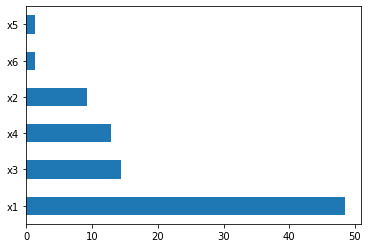

In [14]:
explanation.bar()

We can also get partial explanation.

Contribution of each variable directly involved within the decision policy.

In [15]:
explanation.rule_table()

,Contribution
xgb,0.948
x4,0.640
x1,0.591
lm,0.486
x2,0.000
x3,0.000
x5,0.000
x6,0.000


Contribution for model *lm*.

In [16]:
explanation.model_table('lm')

,Contribution
x6,2.552838e+00
x5,2.269189e+00
x3,-5.672974e-01
x2,2.836487e-01
x4,-2.739652e-16
x1,-2.143130e-16


<AxesSubplot:>

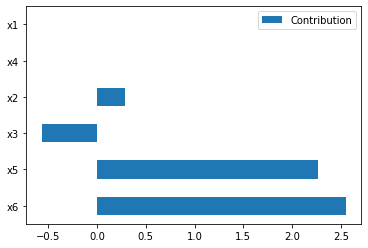

In [17]:
explanation.model_bar('lm')

<AxesSubplot:>

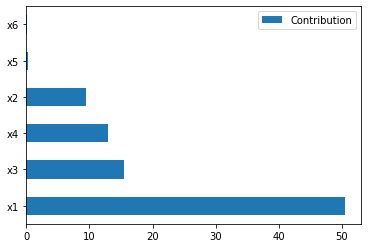

In [18]:
explanation.model_bar('xgb')

We may also wonder why 'dec1' was not made, i.e., why 'rul1' was not triggered.

<AxesSubplot:>

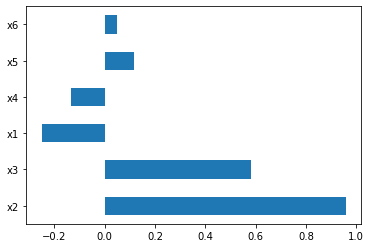

In [19]:
explanation = explainer.explain(example, 'rul1')
explanation.bar()